In [1]:
!cp -r ../input/pytorch-segmentation-models-lib/ ./
!cp -r ../input/torchmetrics/ ./

!pip config set global.disable-pip-version-check true

!pip install -q ./pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q ./pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q ./pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q ./pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl
!pip install -q ./torchmetrics/torchmetrics-0.9.1-py3-none-any.whl

Writing to /root/.config/pip/pip.conf


### https://arxiv.org/pdf/2105.15203.pdf

## Library imports

In [2]:
import pandas as pd
import numpy as np

import os
import json
from tqdm.auto import tqdm
import gc

from skimage import io
from skimage.transform import resize

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning import Trainer

import segmentation_models_pytorch as smp
from torchmetrics.functional import dice

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from operator import itemgetter 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:

!pip install spams
!pip install staintools

import pathlib
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt
import staintools

import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning import Trainer

import segmentation_models_pytorch as smp
from torchmetrics.functional import dice


from operator import itemgetter 

import pandas as pd
from transformers import BertTokenizer, BertModel
from torch.optim import lr_scheduler
from torch import nn
from torch.optim import Adam
from tqdm.notebook import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for spams: filename=spams-2.6.5.4-cp37-cp37m-linux_x86_64.whl size=4693805 sha256=bd61962c33153cdd5b6ce7b87fc57af5c8fbf0ad37b74ab511772aada4e67146
  Stored in directory: /root/.cache/pip/wheels/5e/92/17/e718e0e26bfcdd7e81afcf874ac2bc599dd7dd7f3ad78f9d76
Successfully built spams
  Preparing metadata (setup.py) ... - done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14075 sha256=2b9ee96b022ffdf1ee799c70c221c08130088f86f4613166734b13705e563c83
  Stored in directory: /root/.cache/pip/wheels/9b/ed/74/9d36d40854e911d8e2d2d28d7b67e37e9f176f913ecf34f813
Successfully built staintools


In [4]:
imaging_measurements = {
    'hpa': {
        'pixel_size': {
            'kidney': 0.4,
            'prostate': 0.4,
            'largeintestine': 0.4,
            'spleen': 0.4,
            'lung': 0.4
        },
        'tissue_thickness': {
            'kidney': 4,
            'prostate': 4,
            'largeintestine': 4,
            'spleen': 4,
            'lung': 4
        }
    },
    'hubmap': {
        'pixel_size': {
            'kidney': 0.5,
            'prostate': 6.263,
            'largeintestine': 0.229,
            'spleen': 0.4945,
            'lung': 0.7562
        },
        'tissue_thickness': {
        'kidney': 10,
            'prostate': 5,
            'largeintestine': 8,
            'spleen': 4,
            'lung': 5
        }
    }
}

In [5]:
def augment_image(image, domain_pixel_size, target_pixel_size, domain_tissue_thickness, target_tissue_thickness, alpha=0.15):
    
    
    # Augment tissue thickness
    tissue_thickness_scale_factor = target_tissue_thickness - domain_tissue_thickness
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
    image_hsv[:, :, 1] *= (1 + (alpha * tissue_thickness_scale_factor))
    image_hsv[:, :, 2] *= (1 - (alpha * tissue_thickness_scale_factor))
    image_hsv = image_hsv.astype(np.uint8)
    image_scaled = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    
    # Standardize luminosity
    image_scaled = staintools.LuminosityStandardizer.standardize(image_scaled)

    # Augment pixel size
    pixel_size_scale_factor = domain_pixel_size / target_pixel_size
    image_resized = cv2.resize(
        image_scaled,
        dsize=None,
        fx=pixel_size_scale_factor,
        fy=pixel_size_scale_factor,
        interpolation=cv2.INTER_CUBIC
    )
    
    image_resized = cv2.resize(
        image_resized,
        dsize=(
            image.shape[1],
            image.shape[0]
        ),
        interpolation=cv2.INTER_CUBIC
    )
    
    # Standardize luminosity
    
    from random import randrange
    num = randrange(10)
    
    
    
    image = staintools.LuminosityStandardizer.standardize(image)
    image_augmented = staintools.LuminosityStandardizer.standardize(image_resized)
    
    returnImage = image
    if(num <5):
        returnImage = image_augmented
    
    del image_scaled
    del image_resized
    del image
    del image_augmented
    del image_hsv
    gc.collect()
    
    return returnImage

### Paths definition

In [6]:
TRAIN_IMG_PATH = "../input/hubmap-organ-segmentation/train_images"
TEST_IMG_PATH = "../input/hubmap-organ-segmentation/test_images"

TRAIN_IMG_ANNOTATIONS = "../input/hubmap-organ-segmentation/train_annotations"
TRAIN_IMG_INFO = "../input/hubmap-organ-segmentation/train.csv"

### Auxiliary functions

In [7]:
def rle2mask(mask_rle: str, shape=None, label: int = 0):
    """
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    """
    rle = np.array(list(map(int, mask_rle.split())))
    labels = np.zeros(shape).flatten()
    
    for start, end in zip(rle[::2], rle[1::2]):
        labels[start:start+end] = label

    return labels.reshape(shape).T  # Needed to align to RLE direction


def mask_to_rle(mask):
    #Rescale image to original size
    size = int(len(mask.flatten())**.5)
    n = Image.fromarray(mask.reshape((size, size))*255.0)
    n = np.array(n).astype(np.float32)
    #Get pixels to flatten
    pixels = n.T.flatten()
    #Round the pixels using the half of the range of pixel value
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    pixels = np.nan_to_num(pixels) #incase of zero-div-error
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

### Reading training dataframe

In [8]:
df_train = pd.read_csv(TRAIN_IMG_INFO)

In [9]:
df_train.head(2)

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male


In [10]:
organs = df_train['organ'].unique()

In [11]:
organ_annotations = {}

for i, organ in enumerate(organs):
    organ_annotations[organ] = i+1
    
organ_annotations

{'prostate': 1, 'spleen': 2, 'lung': 3, 'kidney': 4, 'largeintestine': 5}

### Network training config

In [12]:
class Config:
    BATCH_SIZE = 4
    EPOCHS = 6

### Scheduler

In [13]:
class PeakScheduler(torch.optim.lr_scheduler._LRScheduler):
        def __init__(
                self, optimizer,
                epoch_size=-1,
                lr_start   = 0.000001,
                lr_max     = 0.000005 * Config.BATCH_SIZE,
                lr_min     = 0.000001,
                lr_ramp_ep = 4,
                lr_sus_ep  = 0,
                lr_decay   = 0.8,
                verbose = True
            ):
            self.epoch_size = epoch_size
            self.optimizer= optimizer
            self.lr_start = lr_start
            self.lr_max = lr_max
            self.lr_min = lr_min
            self.lr_ramp_ep = lr_ramp_ep
            self.lr_sus_ep = lr_sus_ep
            self.lr_decay = lr_decay
            self.is_plotting = True
            
            epochs = list(range(Config.EPOCHS))
            learning_rates = []
            for i in epochs:
                self.epoch = i
                learning_rates.append(self.get_lr())
            self.is_plotting = False
            self.epoch = 0
            plt.scatter(epochs,learning_rates)
            plt.show()
            super(PeakScheduler, self).__init__(optimizer, verbose=verbose)

        def get_lr(self):
            if not self.is_plotting:
                if self.epoch_size == -1:
                    self.epoch = self._step_count - 1
                else:
                    self.epoch = (self._step_count - 1) / self.epoch_size
                    
            if self.epoch < self.lr_ramp_ep:
                lr = (self.lr_max - self.lr_start) / self.lr_ramp_ep * self.epoch + self.lr_start

            elif self.epoch < self.lr_ramp_ep + self.lr_sus_ep:
                lr = self.lr_max
            else:
                lr = (self.lr_max - self.lr_min) * self.lr_decay**(self.epoch - self.lr_ramp_ep - self.lr_sus_ep) + self.lr_min
            return [lr for _ in self.optimizer.param_groups]


## Hugging face model

In [14]:
from transformers import SegformerForSemanticSegmentation

In [15]:
from PIL import Image

imgs = []

for i, img in enumerate(tqdm(os.listdir(TRAIN_IMG_PATH))):
    
    imgs.append(os.path.join(TRAIN_IMG_PATH, img))

  0%|          | 0/351 [00:00<?, ?it/s]

In [16]:
img_size = 512

class CustomDataset(Dataset):
    def __init__(self, imgs, df, stage):
        self.imgs = imgs
        
        self.df = df
        #print(df)
        #print(df[df['id'] == 28052]['rle'].values[0])
        mean=[196.869/255, 190.186/255, 194.802/255],
        std=[63.01/255, 66.765/255, 65.745/255],
        if stage == 'train':
            self.transforms = A.Compose([
                A.augmentations.crops.RandomResizedCrop(height=img_size, width=img_size),
                A.augmentations.Rotate(limit=90, p=0.5),
                A.augmentations.HorizontalFlip(p=0.5),
                A.augmentations.VerticalFlip(p=0.5),
                A.augmentations.transforms.ColorJitter(p=0.5),
            
                A.OneOf([
                    A.HueSaturationValue(10, 15, 10),
                    A.CLAHE(clip_limit=4),
                    A.RandomBrightnessContrast(),            
                ], p=0.5),                
                A.Normalize(mean=mean, std=std, max_pixel_value=255),
            ])
        else:
            self.transforms = A.Compose([
                A.Resize(img_size, img_size),
                A.Normalize(mean=mean, std=std, max_pixel_value=255),
            ])
            
        
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        
        
        img = self.imgs[idx]
        img_number = int(img.split("/")[-1].split(".")[0])
        rle = self.df[self.df['id'] == img_number]['rle'].values[0]
        height = self.df[self.df['id'] == img_number]['img_height'].values[0]
        width = self.df[self.df['id'] == img_number]['img_width'].values[0]
        organ = self.df[self.df['id'] == img_number]['organ'].values[0]
        
        
        
        img = np.asarray(Image.open(img))
        
        image_augmented = augment_image(
            image=img,
            domain_pixel_size= imaging_measurements['hpa']['pixel_size'][organ],
            target_pixel_size=imaging_measurements['hubmap']['pixel_size'][organ],
            domain_tissue_thickness=imaging_measurements['hpa']['tissue_thickness'][organ],
            target_tissue_thickness=imaging_measurements['hubmap']['tissue_thickness'][organ]
        )
     
        img = image_augmented
        
        
        
        
        mask = rle2mask(rle, shape=(height, width), label=organ_annotations[organ])
        
        transformed = self.transforms(image=img, mask=np.expand_dims(mask, axis=2))
        
        del mask
        del image_augmented
        del img
        gc.collect()
        
        return np.transpose(transformed['image'], (2, 0, 1)).astype(np.float32), np.squeeze(transformed['mask'], 2).astype(np.int16)

In [17]:
class SegmentationModel(pl.LightningModule):
    def __init__(
        self,
        model
        ):
        super(SegmentationModel, self).__init__()
        
        self.model = model
        
        
    def forward(self, image):
        outputs = self.model(pixel_values=image)
        
        upsampled_logits = nn.functional.interpolate(
            outputs.logits,
            size=mask.shape[-2:], 
            mode="bilinear",
            align_corners=False
        )
#         del outputs
#         del image
        gc.collect()
        
        return upsampled_logits
        

    def training_step(self, batch, batch_idx):
        image, mask = batch[0], batch[1]
        outputs = self.model(pixel_values=image, labels=mask.long())
        
        upsampled_logits = nn.functional.interpolate(
            outputs.logits,
            size=mask.shape[-2:], 
            mode="bilinear",
            align_corners=False
        )
        
        loss = outputs.loss
        
#         del outputs
#         del image
        gc.collect()
        
        return {'loss': loss, 'logits_mask': upsampled_logits, 'mask': mask}
    
#     def training_epoch_end(self, outputs):
#         loss = [item['loss'].item() for item in outputs]
#         logits_mask = torch.cat([item['logits_mask'].cpu() for item in outputs]).softmax(1)
#         mask = torch.cat([item['mask'].cpu() for item in outputs])
        
#         pred_mask = logits_mask.argmax(dim=1).float()
        
#         dice_score = dice(
#             logits_mask, 
#             mask
#         ).item()
        
#         log_parameters = {
#             "loss_train": np.mean(loss),
#             "dice_score_train": dice_score
#         }
        
#         print(log_parameters)
        
#         del outputs
#         gc.collect()
        
#         self.log_dict(log_parameters)
    
    def validation_step(self, batch, batch_idx):
        image, mask = batch[0], batch[1]
        outputs = self.model(pixel_values=image, labels=mask.long())
        
        upsampled_logits = nn.functional.interpolate(
            outputs.logits,
            size=mask.shape[-2:], 
            mode="bilinear",
            align_corners=False
        )
        
        loss = outputs.loss
        
        del outputs
        del image
        gc.collect()
        
        return {'loss': loss, 'logits_mask': upsampled_logits, 'mask': mask}
        
    def validation_epoch_end(self, outputs):
        loss = torch.from_numpy(np.array([item['loss'].item() for item in outputs]))
        logits_mask = torch.cat([item['logits_mask'].cpu() for item in outputs]).softmax(1)
        mask = torch.cat([item['mask'].cpu() for item in outputs]).long()
        
        pred_mask = logits_mask.argmax(dim=1).long()
        
        dice_score = dice(
            logits_mask, 
            mask
        ).item()
        
        log_parameters = {
            "loss_valid": torch.mean(loss),
            "dice_score_valid": dice_score
        }
        
        del outputs
        gc.collect()
        
        self.log_dict(log_parameters)        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = PeakScheduler(
            optimizer,
            lr_ramp_ep=int(Config.EPOCHS * 0.3), 
            lr_decay=0.95,
            lr_max=1e-03,
            lr_min=1e-08
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "epoch", "frequency": 1}
        }

In [18]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

0it [00:00, ?it/s]

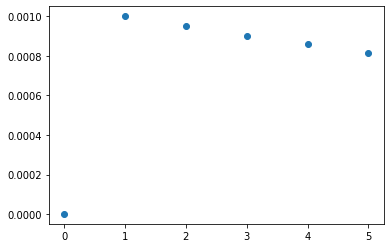

Adjusting learning rate of group 0 to 1.0000e-06.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.5000e-04.
Adjusting learning rate of group 0 to 9.0250e-04.
Adjusting learning rate of group 0 to 8.5738e-04.
Adjusting learning rate of group 0 to 8.1451e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.7378e-04.


In [19]:
fold = 1
torch.cuda.empty_cache()
for train_idx, test_idx in tqdm(kf.split(range(len(imgs)))):
    train_imgs = itemgetter(*train_idx)(imgs)
    valid_imgs = itemgetter(*test_idx)(imgs)
    
    train_dataset = CustomDataset(train_imgs, df_train, 'train')
    valid_dataset = CustomDataset(valid_imgs, df_train, 'valid')

    train_dataloader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, drop_last=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, drop_last=False)
    
#     net = SegformerForSemanticSegmentation.from_pretrained(
#         "nvidia/mit-b5",
#         ignore_mismatched_sizes=True, 
#         num_labels=len(organ_annotations)+1, 
#         reshape_last_stage=True
#     )
    
    net = SegformerForSemanticSegmentation.from_pretrained(
       "../input/unosegformer/Segformer"
    )
    
    trainer = Trainer(
        max_epochs=Config.EPOCHS,
        accelerator="cuda",
        gpus=1,
        precision=32, 
        auto_lr_find=True,
        accumulate_grad_batches=4,
        auto_scale_batch_size=True,
        check_val_every_n_epoch=5
    )

    model = SegmentationModel(net)

    trainer.fit(
        model,
        train_dataloader,
        valid_dataloader,

    )
    
    MODEL_NAME = f"Segformer-fold-{fold}-epochs-{Config.EPOCHS}"

    if not os.path.exists(os.path.join("./", MODEL_NAME)):
        os.mkdir(os.path.join("./", MODEL_NAME))

    model.model.save_pretrained(f"./{MODEL_NAME}")  
    
    fold += 1
    
    break

In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

### You may try to create an inference notebook by yourself or wait a little bit. I will add it to the public! Even with test-time augmentations ;)

### Segformer model with mit-b5 backbone, 3 folds gave me 0.70 Dice score on a public LB.

### If you find this notebook useful, please upvote it.

### If you have any questions, feel free to start discussions in comments =)

#### >>> Work is in progress. Notebook will be updated!

In [21]:
ls

Segformer-fold-1-epochs-6/  lightning_logs/                   torchmetrics/
__notebook__.ipynb          pytorch-segmentation-models-lib/


In [22]:
cd Segformer-fold-1-epochs-6

/kaggle/working/Segformer-fold-1-epochs-6


In [23]:
from IPython.display import FileLink
#%cd ../../..
!cp -r Segformer-fold-1-epochs-6/pytorch_model.bin .
import os
os.chdir(r'/kaggle/working')
FileLink(r'pytorch_model.bin')

cp: cannot stat 'Segformer-fold-1-epochs-6/pytorch_model.bin': No such file or directory


/kaggle/working/pytorch_model.bin

In [24]:
!pwd 

/kaggle/working
